In [1]:
import pygmt
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray
from pyproj import Transformer

# Plotting Function

In [2]:
# make function for a starting point for RIS plots
# default map extent is for Ross Ice Shelf
def start_fig(n = -1600e3, e = -860e3, s = -200e3, w = 670e3, subplots=False):
    global fig, fig_reg, fig_proj, fig_proj_ll, bardwidth, pos_str
    
    #set figure height, width and map scale
    fig_height = 180 # in mm
    fig_width = fig_height*(w-e)/(s-n)
    fig_ratio = (s-n)/(fig_height/1000)

    # Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
    fig_reg = f'{e}/{w}/{n}/{s}'
    fig_proj = f"x1:{fig_ratio}"
    fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

    # colorbar width and position
    barwidth = fig_width/10 * 0.8 # color bar width is 40% of the map width, in cm
    pos_str = f'jBC+w{barwidth}c/.5c+jTC+o0c/.2c+h+e'
    
    # initialize figure
    if subplots==False:
        fig = pygmt.Figure()
    # if adding a suplot, don't re-initialize, but move origin over    
    else:
        fig.shift_origin(xshift=fig_width/10)
    
    # add white background and frame
    fig.coast(region = fig_reg, projection = fig_proj_ll, land = 'white', water = 'white', 
              frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
    
    # plot groundingline and coastlines
    fig.plot(projection=fig_proj, region=fig_reg,
            data=gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\GroundingLine_Antarctica_v02.shp'), 
            pen = '1.2p,black', verbose='e')
    fig.plot(data=gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\Coastline_Antarctica_v02.shp'), 
            pen='1.2p,black', verbose='e')

    # plot graticules overtop, at 4d latitude and 30d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
        fig.basemap(projection = fig_proj_ll, frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
start_fig()

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# ROSETTA-Ice data

In [3]:
# get ROSETTA-Ice gravity data
# switch this to pooch!
file = "C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/rs_2019_grav.csv"
rosetta = pd.read_csv(file)

rosetta.rename(columns={'FAG_levelled':'FA'}, inplace=True)

rosetta_block = pygmt.blockmedian(data=rosetta[["x", "y", "FA"]], 
                                         spacing="1000+e", 
                                         region=fig_reg)
rosetta_grid = pygmt.surface(data=rosetta_block,
              spacing='1000+e', M='1c',
              region=fig_reg,) 
# !gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
# !gmt grdmath -Df layers/ROSETTA_gravity.nc RIS_mask.nc MUL = layers/ROSETTA_gravity.nc
# !gmt grdsample layers/ROSETTA_gravity.nc -Glayers/ROSETTA_gravity.nc -T
print(f'{len(rosetta.FA)=}')
print(f'{len(rosetta_block)=}')
print(f'{len(rosetta_grid)=}')

len(rosetta.FA)=398279
len(rosetta_block)=37401
len(rosetta_grid)=1401


c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


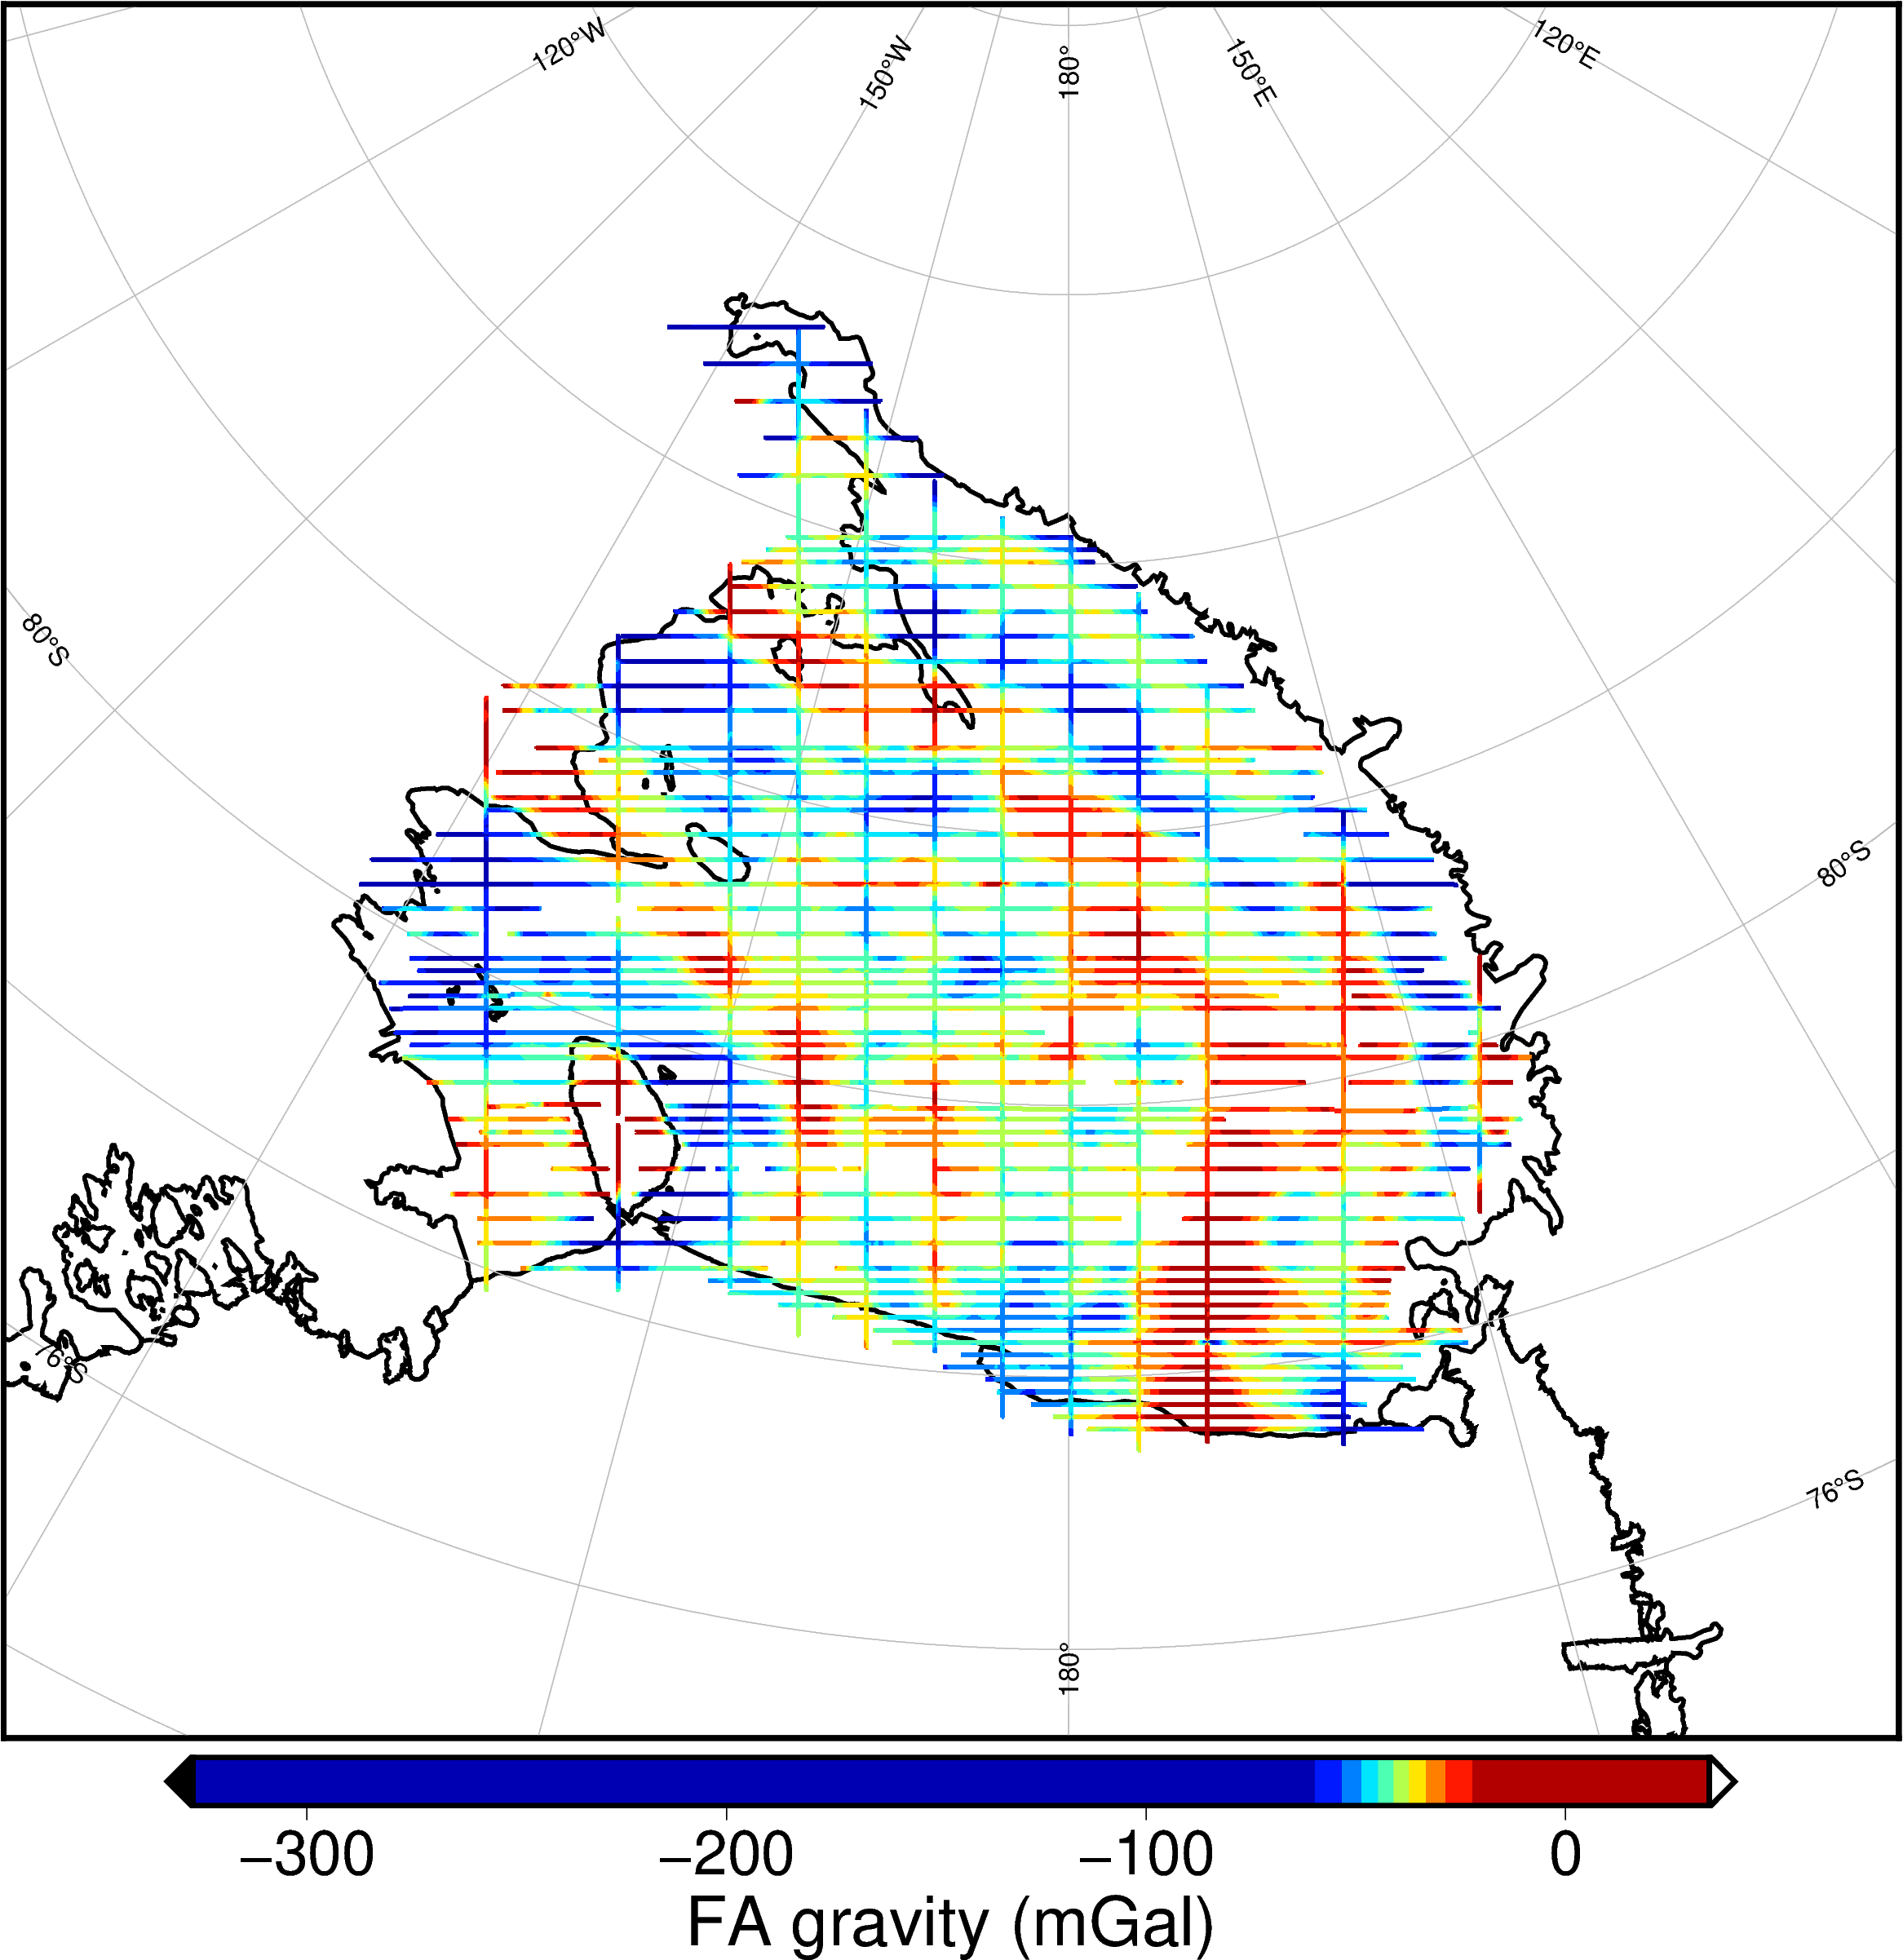

In [4]:
# initialize figure but extend plot north into Ross Sea
# start_fig(n = -2200e3)

start_fig()

# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", grid=rosetta_grid)

# plot grid
fig.grdimage(projection = fig_proj,
             grid=rosetta_grid,
             cmap=True, nan_transparent=True)

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa100f100+l"FA gravity (mGal)"'], verbose='e')     

fig.show() 

# Updated AntGG compilation

In [5]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea) 
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
file ='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.dat'
antgg_update = pd.read_csv(file, delim_whitespace=True, 
                           skiprows=3, names=['id', 'lat', 'lon', 'FA', 'Err', 'DG', 'BA'])

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update['x'], antgg_update['y'] = transformer.transform(antgg_update.lat.tolist(), antgg_update.lon.tolist())

antgg_update = pygmt.blockmedian(antgg_update[["x", "y", "FA"]], 
                                         spacing="10000+e", 
                                         region=fig_reg)

# antgg_update = antgg_update.set_index(['x', 'y'])

# antgg_update=antgg_update[~antgg_update.index.duplicated()]
# # antgg_update.to_xarray()
# xr.Dataset.from_dataframe(antgg_update)

antgg_update_grid = 'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.nc'
pygmt.surface(data=antgg_update[['x','y','FA']], 
                            spacing=10000, 
                            region=fig_reg,
                            M='2c',
                            outgrid=antgg_update_grid
                            )
# antgg_update_tif
# pygmt.grdfill(grid=antgg_update_grid, mode='n', L=True, region=fig_reg)#, outgrid=antgg_update_grid)

surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.


c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


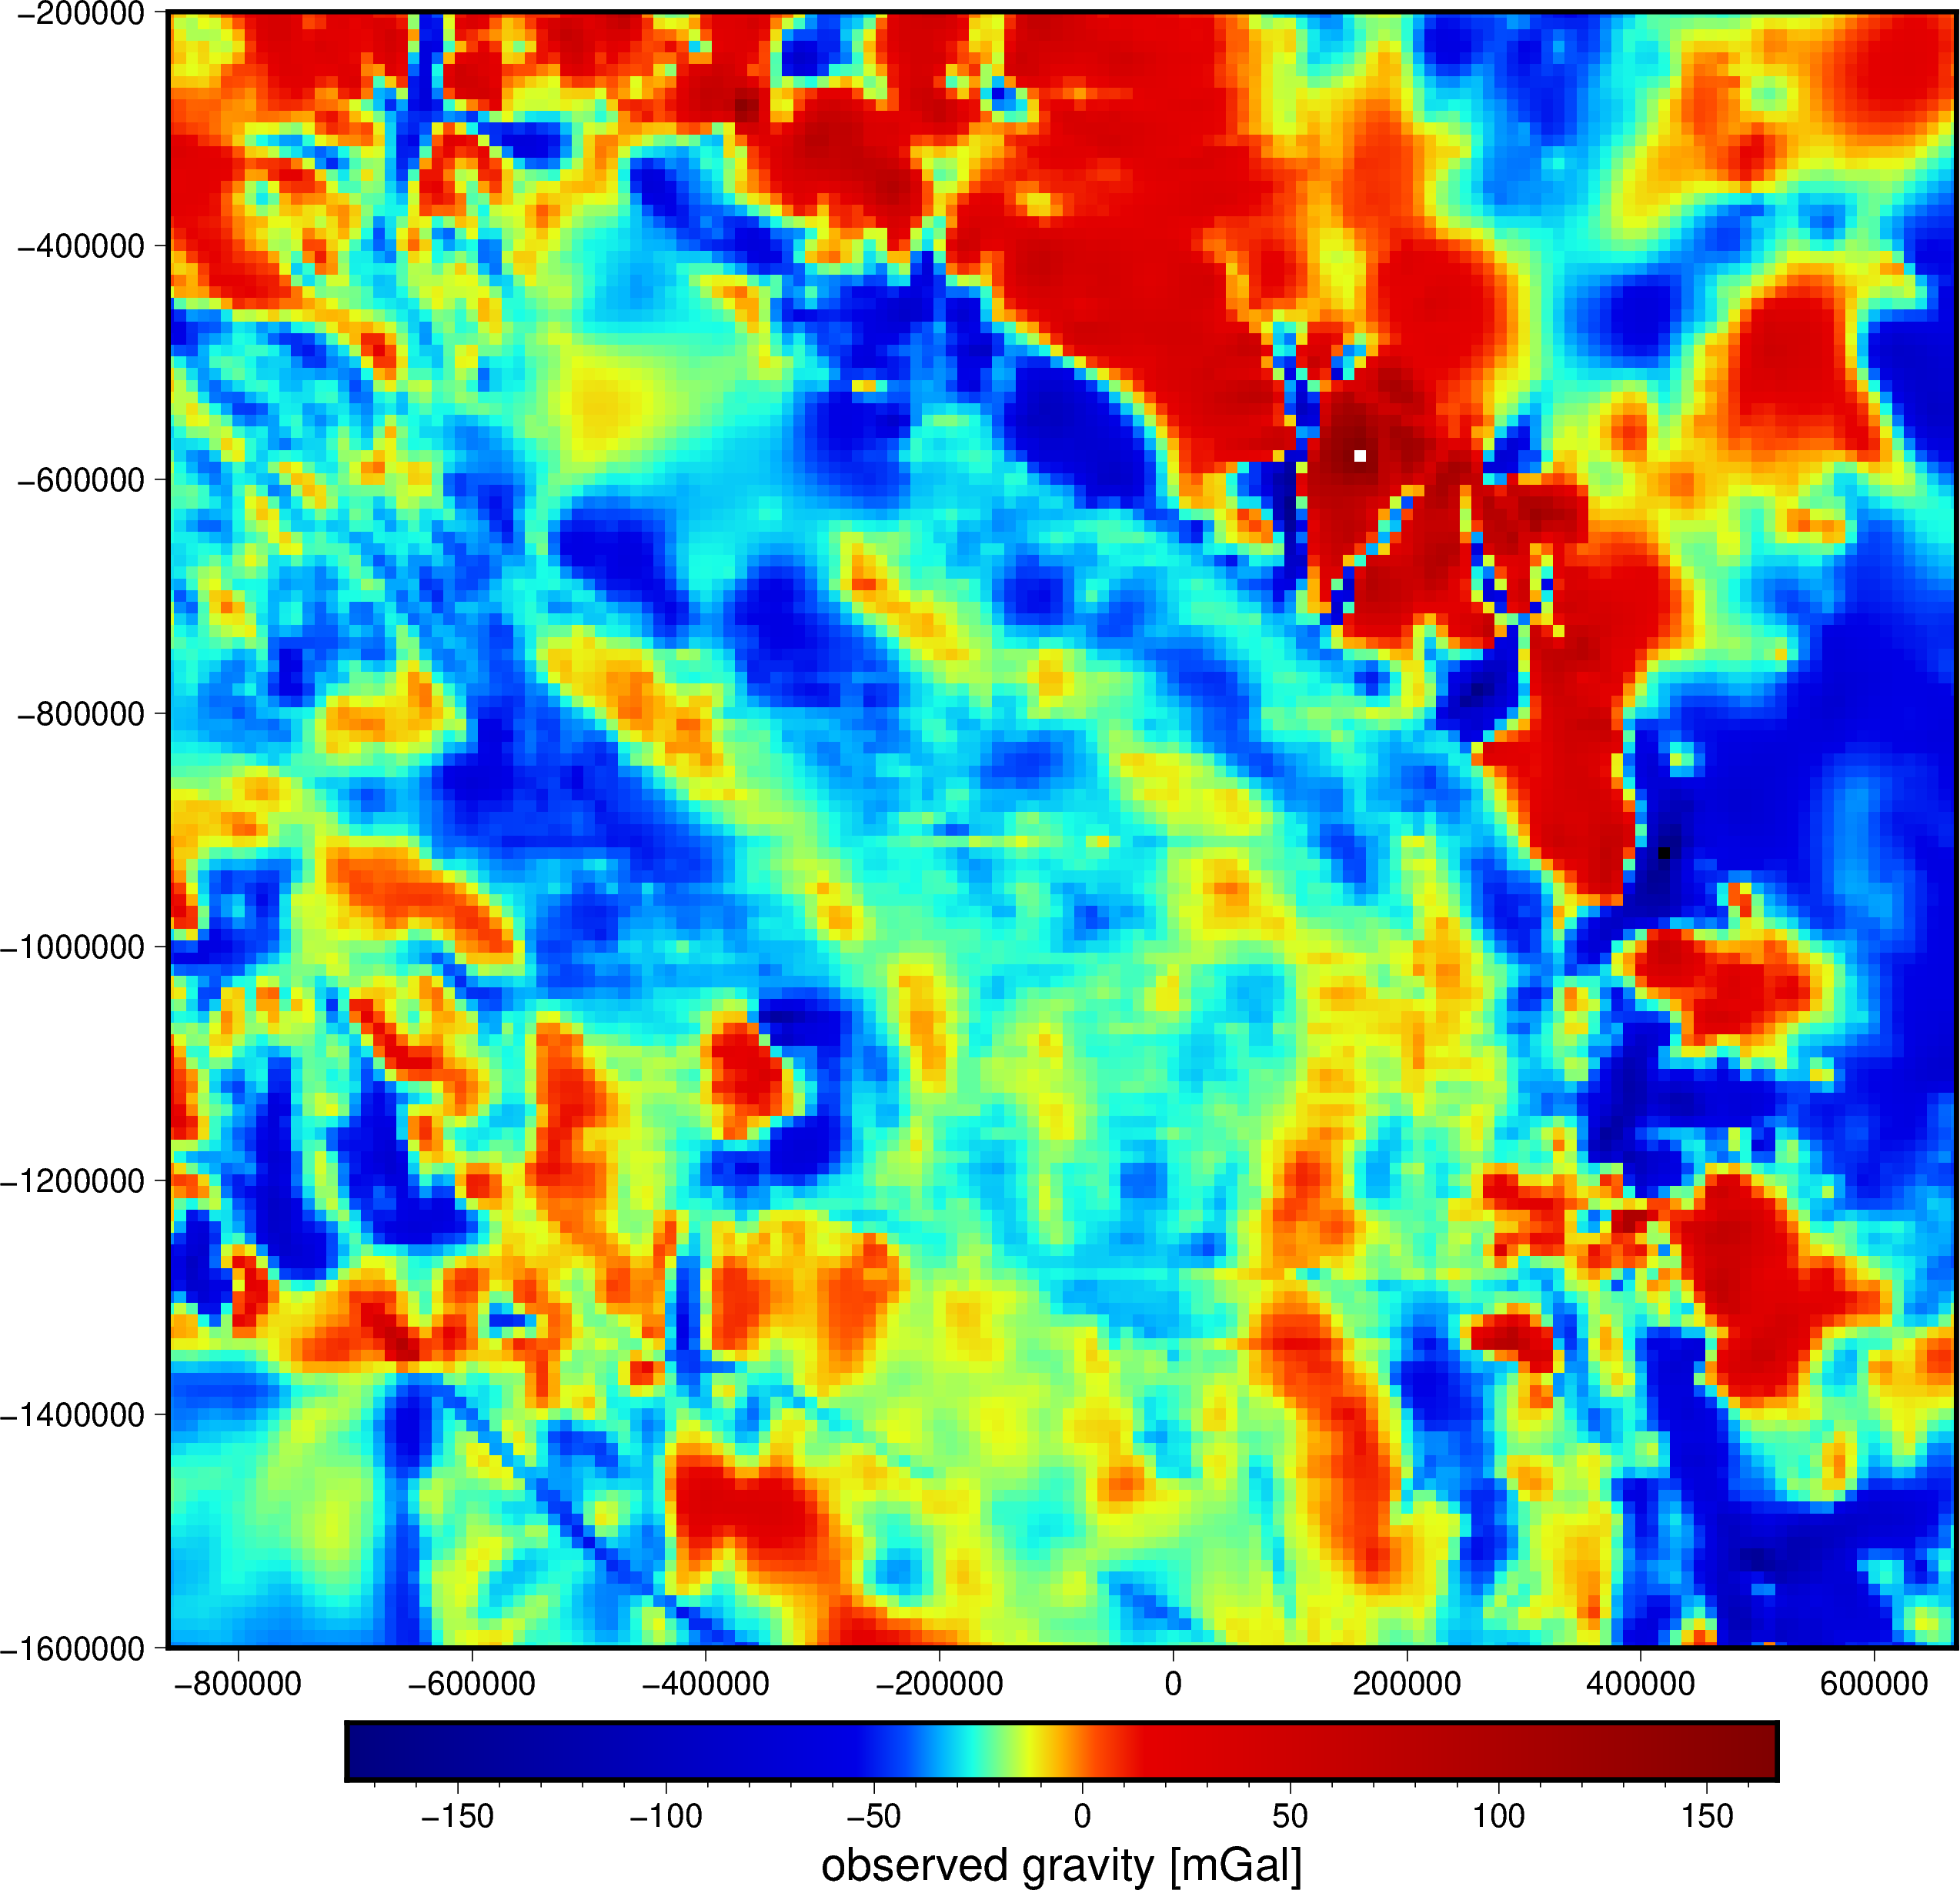

In [6]:
start_fig()
antgg_update_grid='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.nc'
# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", continuous=True, region=fig_reg, grid=antgg_update_grid)
# pygmt.makecpt(cmap="viridis", series=[antgg_update.FA.min(), antgg_update.FA.max()])

# plot grid      
fig.grdimage(grid=antgg_update_grid,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['a','+gwhite'],)

# plot points
# fig.plot(x=antgg_update.x, 
#          y=antgg_update.y, 
#          color=antgg_update.FA,
#          style='c2p',
#          pen='black',
#          projection = fig_proj,
#          region=fig_reg, 
#          cmap=True)



fig.colorbar(frame='af+l"observed gravity [mGal]"')

# colorbar
# with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
#     fig.colorbar(cmap=True, position = pos_str, 
#                  frame=['xa100f100+l"FA gravity (mGal)"'], verbose='e')     

fig.show() 

# Ground Surveys

In [7]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_KIS.csv'
KIS = pd.read_csv(file)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
KIS['x'], KIS['y'] = transformer.transform(KIS.Latitude.tolist(), KIS.Longitude.tolist())

KIS

,Station,Latitude,Longitude,Gobs,Glat,FA,x,y
0,KIS,-82.790560,-155.558750,982973.8674,983113.8221,-139.954713,-324518.823650,-714030.888168
1,KIS,-82.790560,-155.558750,982973.8949,983113.8221,-139.927198,-324518.823650,-714030.888168
2,KIS,-82.790560,-155.558750,982974.0023,983113.8221,-139.819792,-324518.823650,-714030.888168
3,1001,-82.799211,-155.544026,982974.1999,983114.0153,-139.815377,-324311.698991,-713088.594901
4,1003,-82.794832,-155.540327,982974.0597,983113.9175,-139.857863,-324555.467966,-713502.358196
...,...,...,...,...,...,...,...,...
99,3321,-82.780098,-155.607833,982970.0565,983113.5559,-143.499418,-324378.260324,-715347.839677
100,3317,-82.779374,-155.674222,982969.5208,983113.5400,-144.019182,-323581.710342,-715795.210042
101,3313,-82.778654,-155.740949,982965.1858,983113.5241,-148.338366,-322780.140256,-716243.169454
102,3255,-82.777941,-155.808154,982961.5910,983113.8221,-152.231152,-321971.630473,-716692.149669


In [8]:
df=KIS
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

KIS['FA_shift']=KIS.FA+(df.FA.mean()-KIS.FA.mean())

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


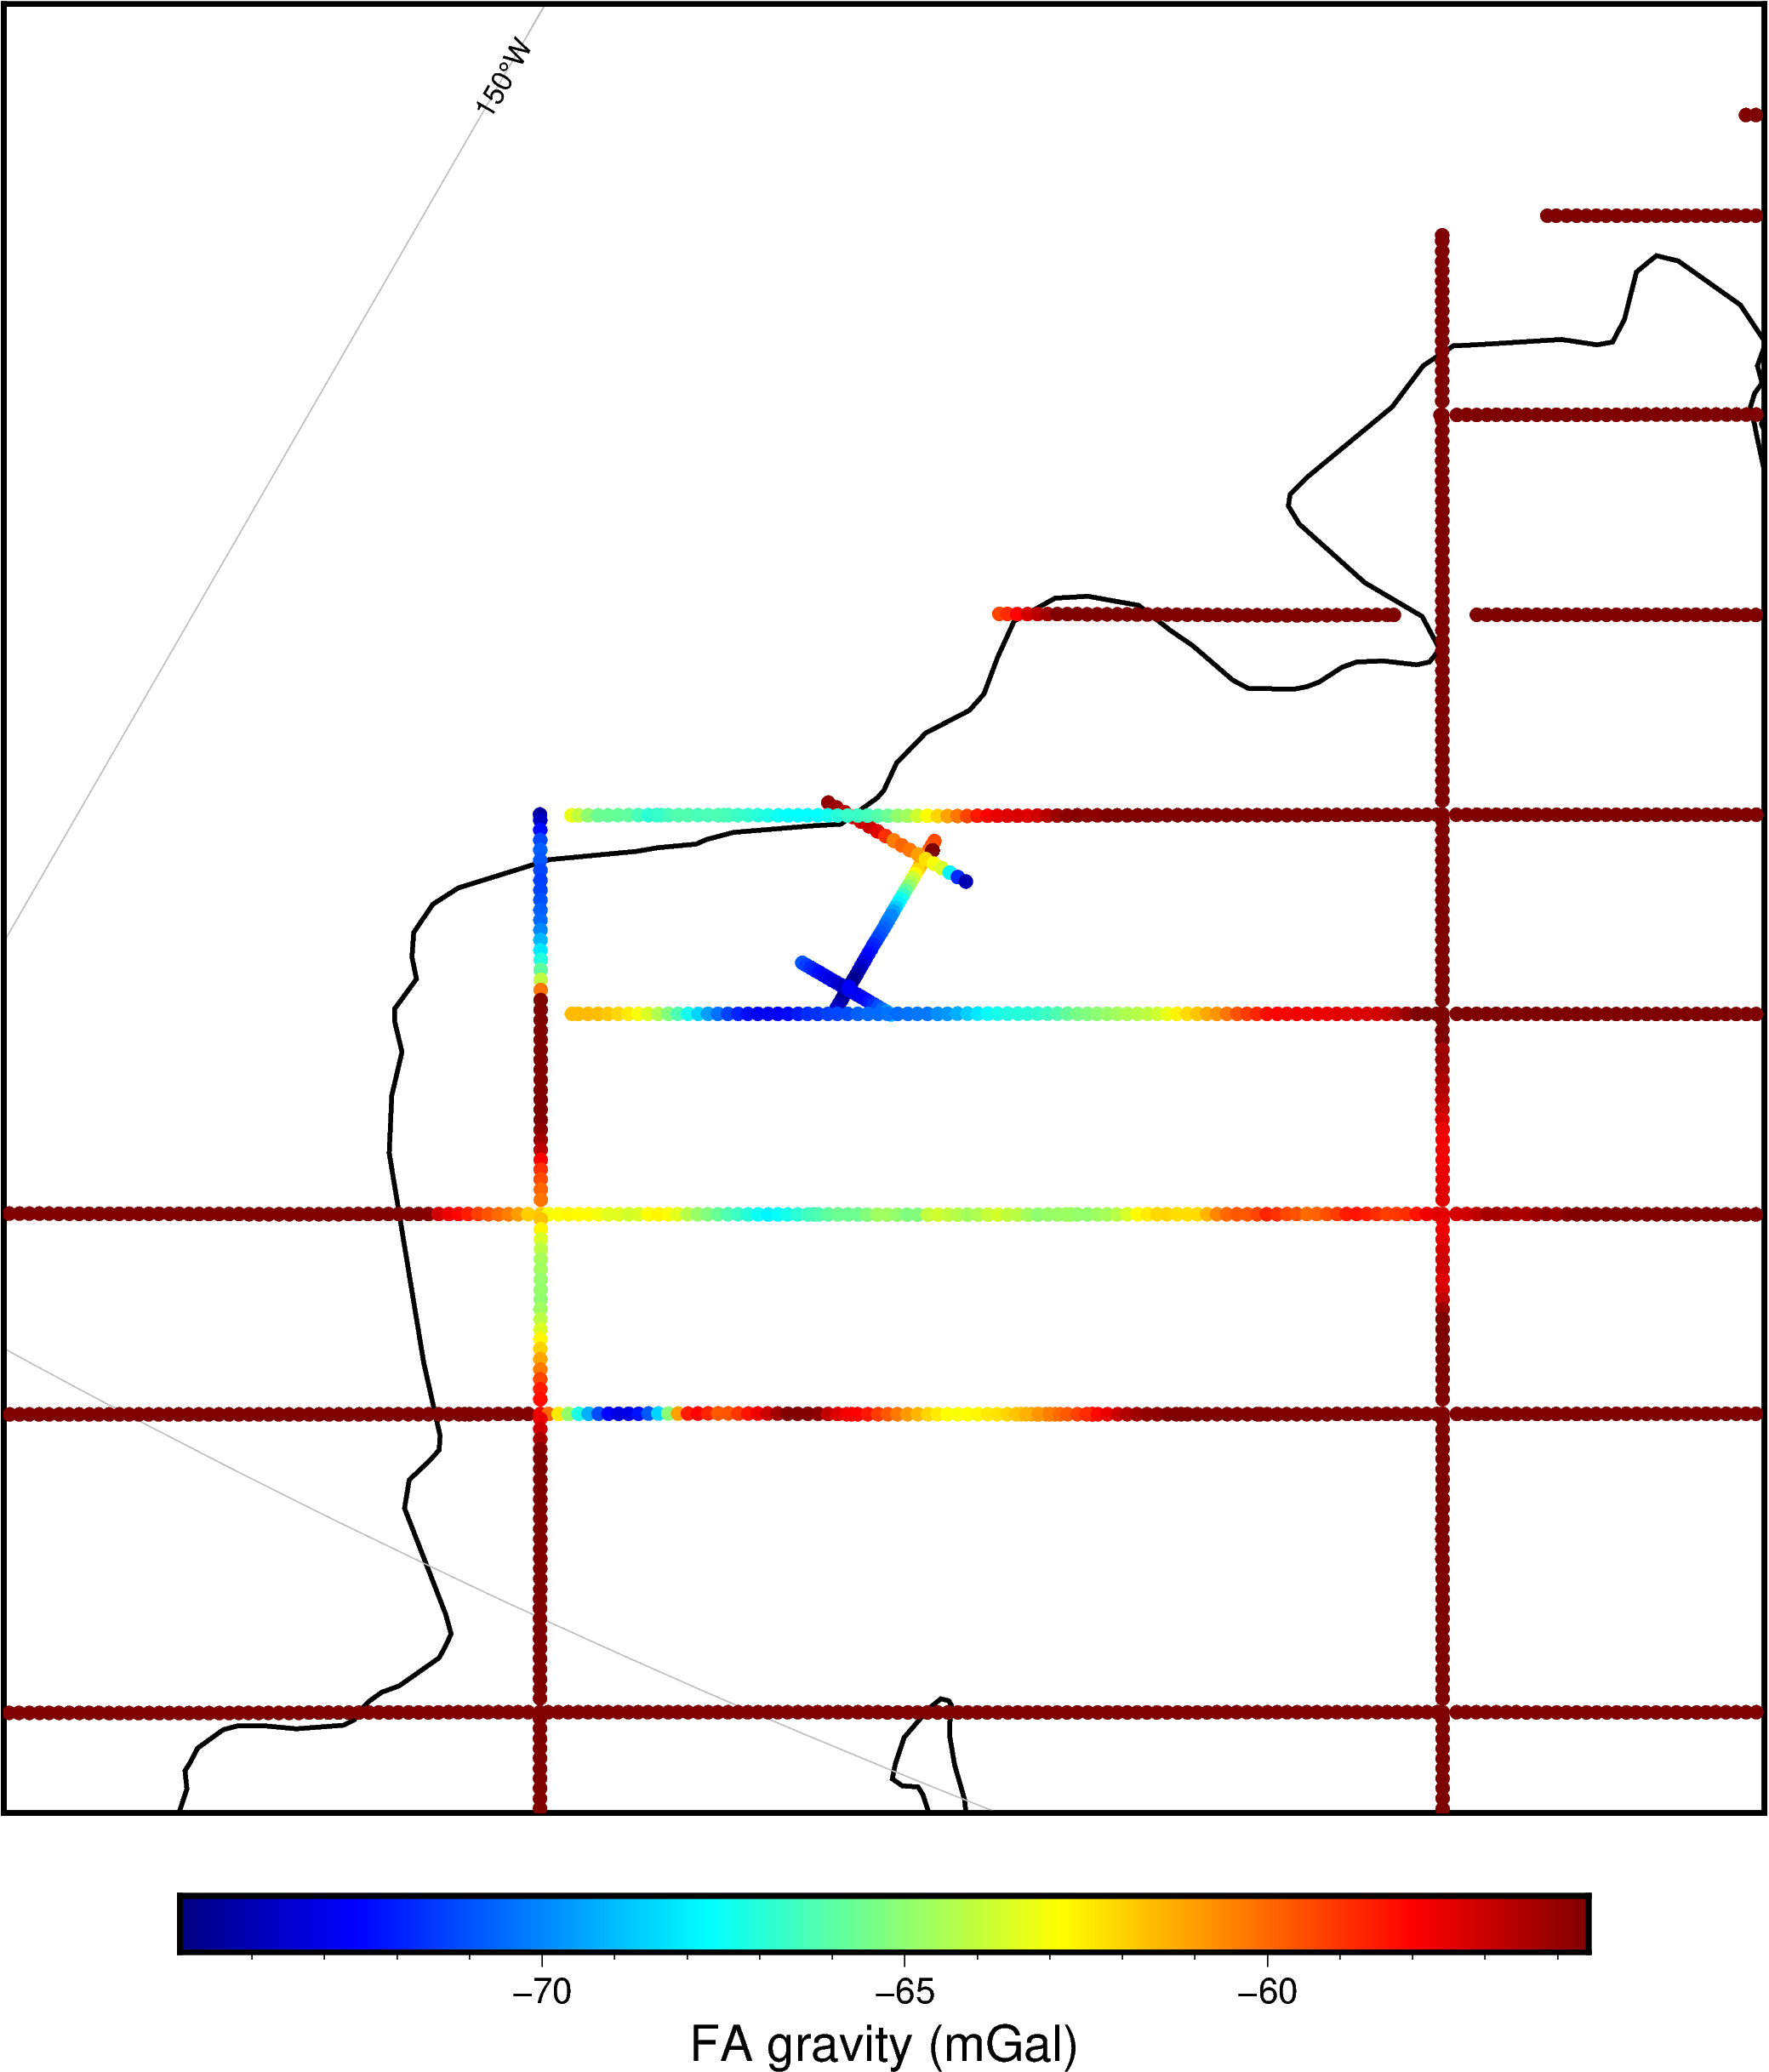

In [9]:
df=KIS
buffer=80e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

start_fig(n=n, s=s, e=e, w=w)


df=KIS
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [10]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_DD_2feb22.csv'
DD = pd.read_csv(file)
DD.drop(columns=['Free air anomaly', 'Free air effect'], inplace=True)
DD['FA']=DD['Absolute Gravity']-DD['Ellipsoidal gravity']+(DD.Elevation*0.3086)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
DD['x'], DD['y'] = transformer.transform(DD.Latitude.tolist(), DD.Longitude.tolist())
DD

,Name,Absolute Gravity,Standard Error,Number of Observations,Latitude,Longitude,Elevation,Ellipsoidal gravity,FA,x,y
0,L100,982949.323,0.158,4,-79.158072,164.938367,0,983034.3639,-85.0409,306992.931056,-1.140803e+06
1,L104,982950.026,0.172,2,-79.156452,164.983028,0,983034.3095,-84.2835,306149.604097,-1.141214e+06
2,L108,982949.823,0.172,2,-79.154740,165.027457,0,983034.2520,-84.4290,305313.051406,-1.141632e+06
3,L112,982950.429,0.172,2,-79.153128,165.072388,0,983034.1979,-83.7689,304463.204942,-1.142042e+06
4,L116,982950.317,0.172,2,-79.151432,165.117257,0,983034.1409,-83.8239,303616.504318,-1.142459e+06
...,...,...,...,...,...,...,...,...,...,...,...
130,x3,982966.633,0.173,2,-79.129795,166.345510,0,983033.4132,-66.7802,279617.434701,-1.151009e+06
131,x4r21,982968.316,0.173,2,-79.139907,166.358085,0,983033.7534,-65.4374,279103.430292,-1.149994e+06
132,x5,982969.233,0.173,2,-79.146705,166.365837,0,983033.9820,-64.7490,278772.218405,-1.149307e+06
133,x6,982970.514,0.173,2,-79.155190,166.375162,0,983034.2671,-63.7531,278366.113387,-1.148449e+06


c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


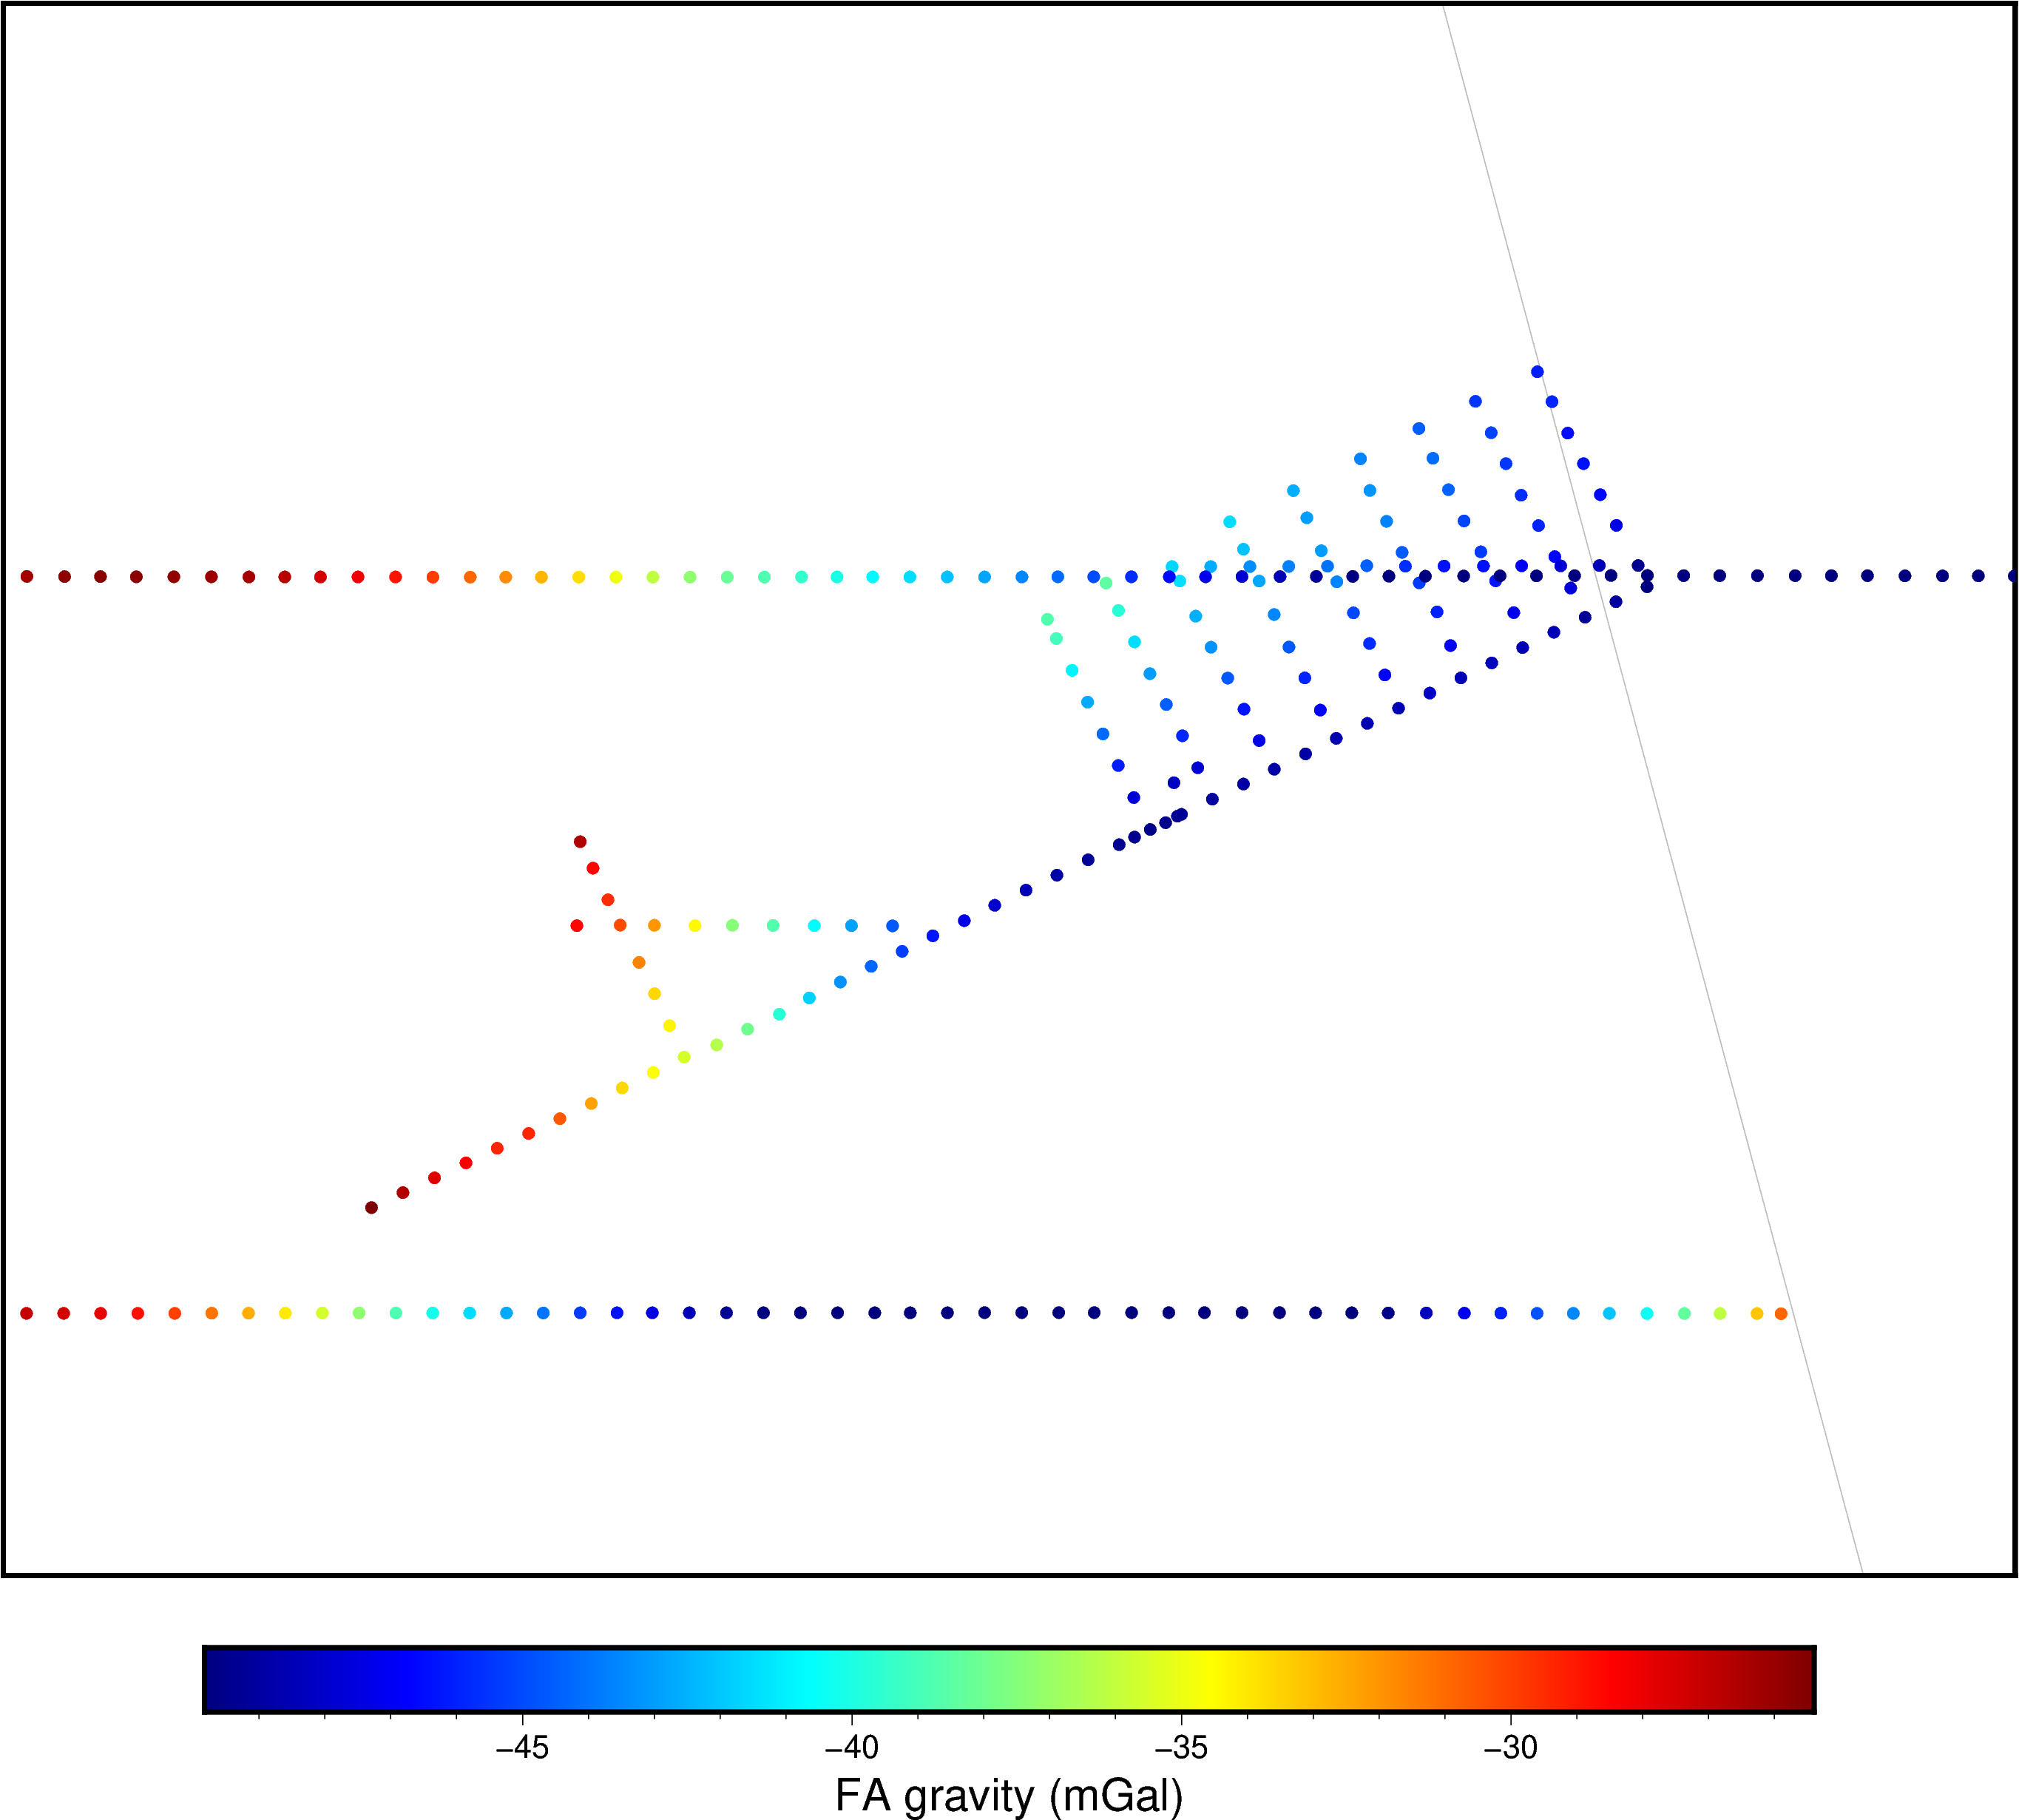

In [11]:
df=DD
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

DD['FA_shift']=DD.FA+(df.FA.mean()-DD.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=DD
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [12]:
fig_reg

'262352.6561105874/316992.9310561905/-1167665.3495458686/-1124962.9037583338'

In [22]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/wgz_fa.csv'
WGZ = pd.read_csv(file)
WGZ.rename(columns={'free-air_disturbance(mGal)':'FA', 'PSX(m)':'x', 'PSY(m)':'y'}, inplace=True)
# transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
# WGZ['x'], WGZ['y'] = transformer.transform(WGZ.Latitude.tolist(), WGZ.Longitude.tolist())
WGZ

,%Latitude,Longitude,x,y,elevation_WGS84(m),elevation_uncertainty(m),FA,uncertainty_free-air(mGal)
0,-84.320965,-163.978417,-170436.903,-593540.172,51.515,0.055,-39.091,0.017
1,-84.331054,-163.722755,-172775.682,-591718.996,50.979,0.052,-36.388,0.017
2,-84.305300,-163.617060,-174658.074,-594090.260,58.021,NaN,-33.623,0.012
3,-84.315240,-163.357940,-177033.013,-592257.078,58.329,NaN,-30.655,0.011
4,-84.341310,-163.458395,-175185.993,-589844.831,51.639,0.033,-33.644,0.024
...,...,...,...,...,...,...,...,...
75,-84.131019,-164.982978,-165365.276,-616419.041,51.736,0.054,-40.292,0.039
76,-84.105564,-164.880034,-167195.762,-618797.612,55.093,0.042,-38.038,0.027
77,-84.094971,-165.126864,-164824.627,-620627.407,50.155,0.064,-39.622,0.034
78,-84.120429,-165.231551,-162983.501,-618246.090,51.328,0.019,-42.986,0.047


c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


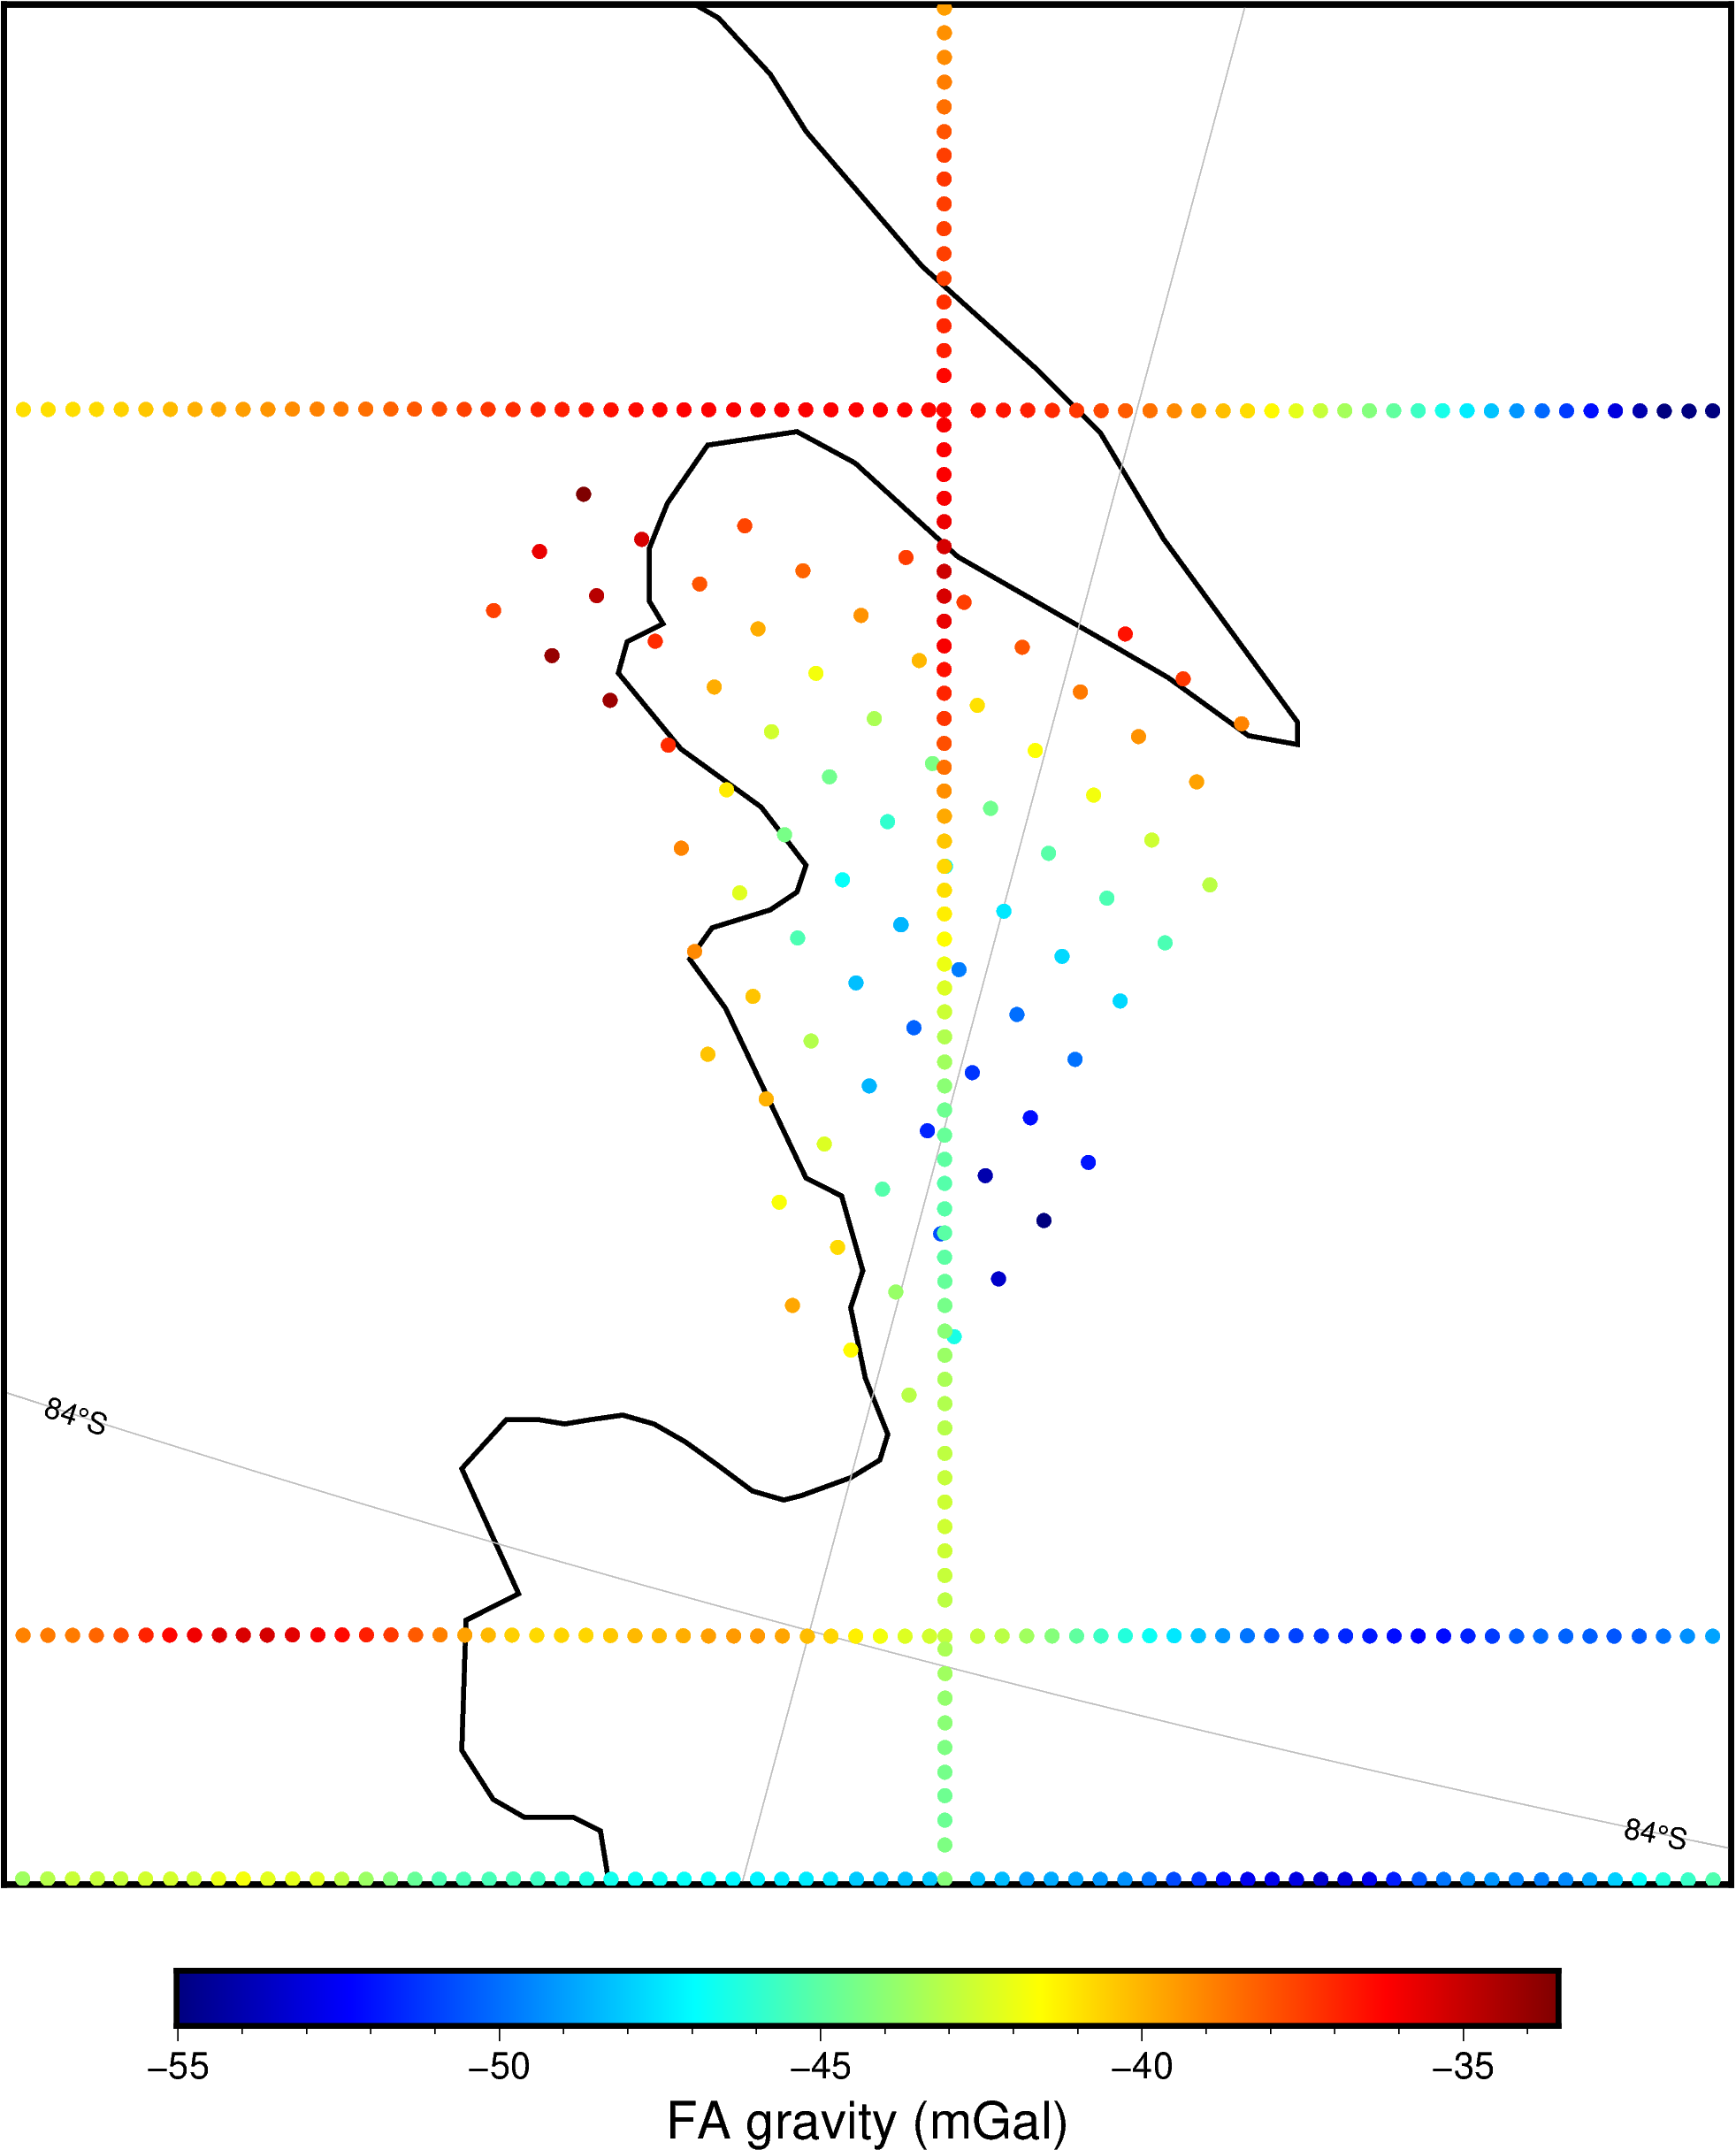

In [24]:
df=WGZ
buffer=20e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

WGZ['FA_shift']=WGZ.FA+(df.FA.mean()-WGZ.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=WGZ
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 